## GPT3 Classification

- Offical Documentation https://beta.openai.com/docs/guides/classifications
- For best practices, follow: https://beta.openai.com/docs/guides/classifications

### Basic Processes 

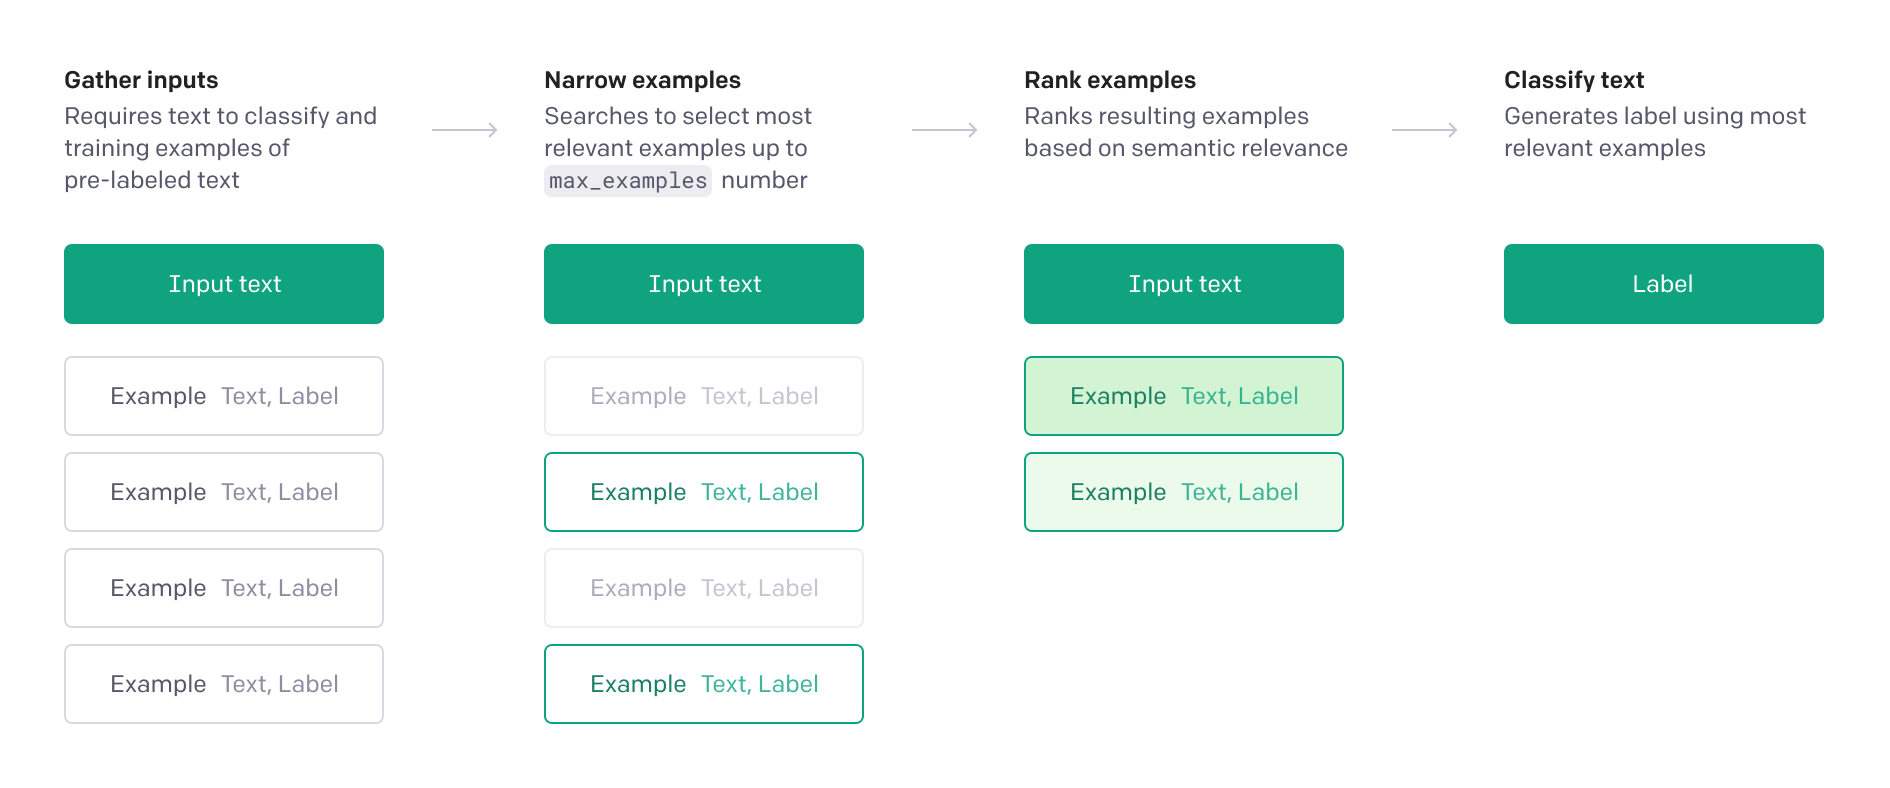

In [1]:
from IPython import display
display.Image("https://cdn.openai.com/API/docs/images/diagram-classification.png")

In [16]:
import openai
import os,sys
import numpy as np
from transformers import GPT2TokenizerFast

sys.path.insert(0,'../lib')
from utils import load_json,load_jsonl

/home/chengyu/anaconda3/envs/gpt3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
key_path = '../../GPT_SECRET_KEY.json'
openai.api_key = load_json(key_path)['API_KEY']

### An example of using some twitter data

In [4]:
data_path = '../../data/tweets_train.jsonl'
result = load_jsonl(data_path)

In [5]:
result[:2]

[{'text': 'great speech of which have speed tracked the revision of energy subsidies so that parents in do not have to decide between protecting their children from the cold this winter and protecting them from breakdown rhetoric will not save us',
  'label': 'Positive',
  'metadata': {'id': 1.45e+18}},
 {'text': 'climate finance',
  'label': 'Positive',
  'metadata': {'id': 1.45e+18}}]

In [6]:
## use File api to upload traning data to server as jsonl format
train_file = openai.File.create(file=open(data_path), purpose="classifications")

In [7]:
print('file id:\n  {}'.format(train_file['id']))

file id:
  file-bOSKtrMOBNRD8JzsaFZzyEBC


In [8]:
### get all uploaded files 
print(openai.File.list())

{
  "data": [
    {
      "bytes": 286,
      "created_at": 1646426682,
      "filename": "classification_data.jsonl",
      "id": "file-wNKIAlKoMvIzz6lTd08EqbVB",
      "object": "file",
      "purpose": "classifications",
      "status": "processed",
      "status_details": null
    },
    {
      "bytes": 26925,
      "created_at": 1646435762,
      "filename": "tweets_train.jsonl",
      "id": "file-AuVK0dP4U58KSZMfH5ZpWkyx",
      "object": "file",
      "purpose": "classifications",
      "status": "processed",
      "status_details": null
    },
    {
      "bytes": 26925,
      "created_at": 1646597709,
      "filename": "tweets_train.jsonl",
      "id": "file-bOSKtrMOBNRD8JzsaFZzyEBC",
      "object": "file",
      "purpose": "classifications",
      "status": "processed",
      "status_details": null
    }
  ],
  "object": "list"
}


In [82]:
labels = ["Positive","Neutral","Negative"]

result = openai.Classification.create(
    file=train_file['id'],
    query="so the bill is going from working on climate change paid family leave free community college to what a bunch of subsidies for large corporations",
    search_model="ada", 
    model="text-davinci-001",   #"text-davinci-001"; "curie"
    temperature=0.0,
    logprobs=4,
    labels=labels,
    max_examples=30
)
print("completation lable:{}".format(result["label"]))
print("completation log probabilities: \n {}".format(
    result["completion"]["choices"][0]["logprobs"]["top_logprobs"][0]))

res_examples = result["selected_examples"]
l = sorted(res_examples, key = lambda i: i['score'],reverse=True)
print("Top match example info : label {}; score {} \n {}".format(l[0]['label'],l[0]["score"],l[0]["text"]))

completation lable:Neutral
completation log probabilities: 
 {
  "\n": -4.897617,
  " Negative": -3.3157537,
  " Neutral": -0.050378535,
  "Ne": -6.1314178
}
Top match example info : label Neutral; score 500.244 
 so the bill is going from working on climate change paid family leave free community college to what a bunch of subsidies for large corporations


### Compare with direct query

In [79]:
task = "Decide whether a Tweet's sentiment is Positive, Neutral, or Negative."
task = '{}\n\n'.format(task)
q = """Tweet: so the bill is going from working on climate change paid family leave free community college to what a bunch of subsidies for large corporations
Sentiment:"""
prompt = task + q 
print(prompt)

response = openai.Completion.create(
    engine="text-davinci-001",
    prompt=prompt,
    logprobs=4,
    temperature=0.1
)
print(response["choices"][0]["logprobs"]["top_logprobs"][0])

Decide whether a Tweet's sentiment is Positive, Neutral, or Negative.

Tweet: so the bill is going from working on climate change paid family leave free community college to what a bunch of subsidies for large corporations
Sentiment:
{
  "\n": -4.776254,
  " Negative": -0.05096632,
  " Neutral": -3.5282342,
  " negative": -4.962763
}


### Get prediction probability 

In [83]:
# Load the tokenizer.
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

# Make sure the labels are formatted correctly.
labels = ["Positive","Neutral","Negative"]
labels = [label.strip().lower().capitalize() for label in labels]

# Encode the labels with extra white space prepended.
labels_tokens = {label: tokenizer.encode(" " + label) for label in labels}
print(labels_tokens)

{'Positive': [33733], 'Neutral': [25627], 'Negative': [36183]}


In [84]:
first_token_to_label = {tokens[0]: label for label, tokens in labels_tokens.items()}
top_logprobs = result["completion"]["choices"][0]["logprobs"]["top_logprobs"][0]
token_probs = {
    tokenizer.encode(token)[0]: np.exp(logp) 
    for token, logp in top_logprobs.items()
}
label_probs = {
    first_token_to_label[token]: prob 
    for token, prob in token_probs.items()
    if token in first_token_to_label
}
# Fill in the probability for the special "Unknown" label.
if sum(label_probs.values()) < 1.0:
    label_probs["Unknown"] = 1.0 - sum(label_probs.values())

print(label_probs)

{'Negative': 0.03630667392236186, 'Neutral': 0.9508694190121482, 'Unknown': 0.01282390706548997}
